In this notebook we will study the energy conservation properties of several high-order methods for the Hénon–Heiles system. We will se how the energy error behaves at very thight tolerances and how different techniques such as using symplectic solvers or manifold projections benchmark against each other.
The Hamiltonian for this system is given by:
$$
\mathcal{H}=\frac{1}{2}(p_1^2 + p_2^2) + \frac{1}{2}\left(q_1^2 + q_2^2 + 2q_1^2 q_2 - \frac{2}{3}q_2^3\right)
$$

We will also compare the in place apporach with the out of place approach by using `Array`s (for the in place version) and `StaticArrays` (for out of place versions). In order to separate these two, we will define the relevant functions and initial conditions in the `InPlace` and `OutofPlace` modules. In this way the rest of the code will work for both.

In [1]:
using DifferentialEquations, Plots
using TaylorIntegration
pyplot()

T(p) = 1//2 * sum(p.^2)
V(q) = 1//2 * (q[1]^2 + q[2]^2 + 2q[1]^2 * q[2]- 2//3 * q[2]^3)
H(q, p) = T(p) + V(q)

module InPlace
using ParameterizedFunctions

function q̇(t, q, p, dq)
    dq[1] = p[1]
    dq[2] = p[2]
end

function ṗ(t, q, p, dp)
    dp[1] = -q[1] * (1 + 2q[2])
    dp[2] = -q[2] - (q[1]^2 - q[2]^2)
end

const q0 = [0.1, 0.]
const p0 = [0., 0.5]
const u0 = vcat(q0, p0)

henon = @ode_def_noinvjac HamiltonEqs begin
    dq1 = p1
    dq2 = p2
    dp1 = -q1 * (1 + 2q2)
    dp2 = -q2 - (q1^2 - q2^2)
end

end

module OutOfPlace
using StaticArrays

function q̇(t, q, p)
    p
end

function ṗ(t, q, p)
    dp1 = -q[1] * (1 + 2q[2])
    dp2 = -q[2] - (q[1]^2 - q[2]^2)
    @SVector [dp1, dp2]
end

const q0 = @SVector [0.1, 0.]
const p0 = @SVector [0., 0.5]
const u0 = vcat(q0, p0)

henon(t, z) = SVector(
    z[3],
    z[4],
    -z[1] * (1 + 2z[2]), 
    -z[2] - (z[1]^2 - z[2]^2))
end

const E = H(InPlace.q0, InPlace.p0)
function g(u, resid)
    resid[1] = H([u[1],u[2]],[u[3],u[4]]) - E
    resid[2:4] .= 0
end

const cb = ManifoldProjection(g, nlopts=Dict(:ftol=>1e-13));

For the comparison we will use the following function.

In [2]:
energy_err(sol) = map(i->H([sol[1,i], sol[2,i]], [sol[3,i], sol[4,i]])-E, 1:length(sol.u))
abs_energy_err(sol) = [abs.(H([sol[1,j], sol[2,j]], [sol[3,j], sol[4,j]]) - E) for j=1:length(sol.u)]

function compare(mode=InPlace, dyn_only=false, plt=nothing; tmax=1e2)
    prob1 = DynamicalODEProblem(mode.q̇, mode.ṗ, mode.q0, mode.p0, (0., tmax))
    if (mode == InPlace && !dyn_only)
        prob2 = ODEProblem(mode.henon, mode.u0, (0., tmax))
    end
    gc()
    (mode == InPlace  && !dyn_only) && @time sol1 = solve(prob2, Vern9(), callback=cb, abstol=1e-14, reltol=1e-14)
    @time sol2 = solve(prob1, KahanLi8(), dt=1e-2, maxiters=1e10)
    @time sol3 = solve(prob1, Vern9(), abstol=1e-14, reltol=1e-14)
    @time sol4 = solve(prob1, DPRKN12(), abstol=1e-14, reltol=1e-14)
    (mode == InPlace && !dyn_only) && @time sol5 = solve(prob2, TaylorMethod(50), abstol=1e-20)
    
    (mode == InPlace && !dyn_only) && println("Vern9 + ManifoldProjection max energy error: ", maximum(abs_energy_err(sol1)))
    println("KahanLi8 max energy error: ",                   maximum(abs_energy_err(sol2)))
    println("Vern9 max energy error: ",                      maximum(abs_energy_err(sol3)))
    println("DPRKN12 max energy error: ",                    maximum(abs_energy_err(sol4)))
    (mode == InPlace && !dyn_only) && println("TaylorMethod max energy error: ",               maximum(abs_energy_err(sol5)))
    
    if plt == nothing
        plt = plot(xlabel="t", ylabel="Energy error")
    end
    (mode == InPlace && !dyn_only) && plot!(sol1.t, energy_err(sol1), label="Vern9 + ManifoldProjection")
    plot!(sol2.t, energy_err(sol2), label="KahanLi8", ls=mode==InPlace?:solid : :dash)
    plot!(sol3.t, energy_err(sol3), label="Vern9", ls=mode==InPlace?:solid : :dash)
    plot!(sol4.t, energy_err(sol4), label="DPRKN12", ls=mode==InPlace?:solid : :dash)
    (mode == InPlace && !dyn_only) && plot!(sol5.t, energy_err(sol5), label="TaylorMethod")
    
    return plt
end

compare (generic function with 4 methods)

The `mode` argument choses between the in place approach
and the out of place one. The `dyn_only` parameter is used to compare only the integrators that are compatible with
`DynamicalODEProblem` and those coincide with the integrators that support both the in place and the out of place
versions (we reffer here only to the 5 high order methods chosen bellow). The `plt` argument can be used to overlay the results over a previous plot and the `tmax` keyword determines the simulation time.

Note: The `NLsolve` call used by `ManifoldProjection` was modified to use `ftol=1e-13` in order to obtain a very low energy error.

Here are the results of the comparisons between the in place methods:

  0.006933 seconds (57.56 k allocations: 8.475 MiB)
  0.010481 seconds (190.21 k allocations: 10.319 MiB)
  0.051303 seconds (1.58 M allocations: 26.838 MiB, 49.77% gc time)
  0.000709 seconds (9.00 k allocations: 407.922 KiB)
  0.029828 seconds (173.95 k allocations: 60.718 MiB, 60.73% gc time)
Vern9 + ManifoldProjection max energy error: 5.551115123125783e-16
KahanLi8 max energy error: 4.9404924595819466e-15
Vern9 max energy error: 1.4988010832439613e-15
DPRKN12 max energy error: 2.220446049250313e-15
TaylorMethod max energy error: 1.6653345369377348e-16



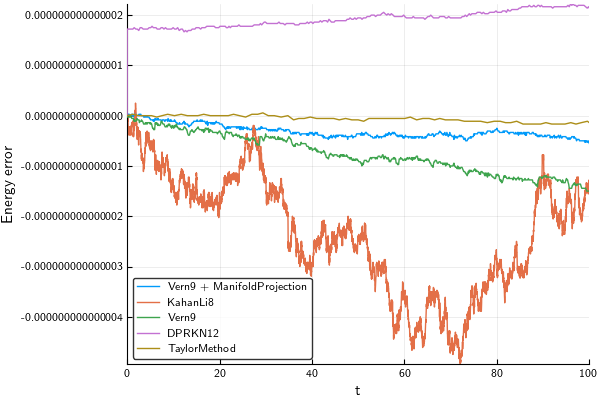

In [4]:
compare(tmax=1e2)

  0.087227 seconds (569.31 k allocations: 84.296 MiB, 24.43% gc time)
  0.283956 seconds (1.90 M allocations: 101.091 MiB, 58.72% gc time)
  0.802834 seconds (15.78 M allocations: 267.808 MiB, 70.34% gc time)
  0.006242 seconds (82.56 k allocations: 3.604 MiB)
  0.411077 seconds (1.72 M allocations: 261.793 MiB, 73.35% gc time)
Vern9 + ManifoldProjection max energy error: 5.578870698741412e-15
KahanLi8 max energy error: 1.815214645262131e-14
Vern9 max energy error: 1.3933298959045715e-14
DPRKN12 max energy error: 3.1363800445660672e-15
TaylorMethod max energy error: 5.551115123125783e-16



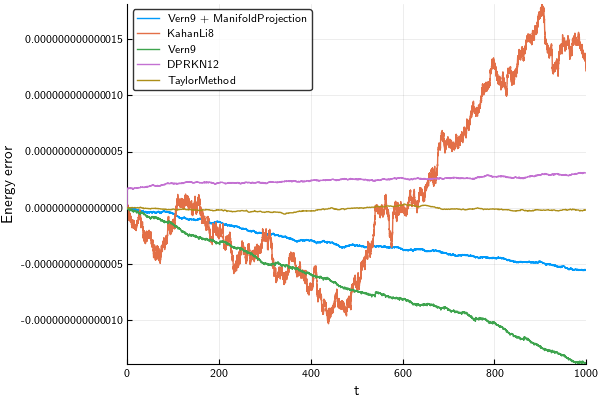

In [5]:
compare(tmax=1e3)

  1.678306 seconds (5.69 M allocations: 840.096 MiB, 59.48% gc time)
  2.338311 seconds (19.00 M allocations: 966.797 MiB, 52.87% gc time)
 10.593894 seconds (157.84 M allocations: 2.613 GiB, 76.86% gc time)
  0.101857 seconds (819.27 k allocations: 35.250 MiB, 45.27% gc time)
  4.147282 seconds (17.22 M allocations: 2.220 GiB, 70.32% gc time)
Vern9 + ManifoldProjection max energy error: 4.50195436485501e-14
KahanLi8 max energy error: 3.1585845050585704e-14
Vern9 max energy error: 1.22291066162461e-13
DPRKN12 max energy error: 1.607047828144914e-14
TaylorMethod max energy error: 2.7200464103316335e-15



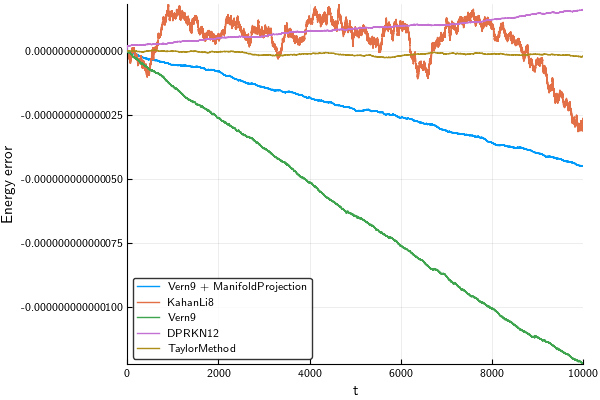

In [6]:
compare(tmax=1e4)

 11.814311 seconds (28.44 M allocations: 4.077 GiB, 71.59% gc time)
 22.225052 seconds (95.00 M allocations: 4.799 GiB, 73.08% gc time)
181.643562 seconds (789.20 M allocations: 13.041 GiB, 92.58% gc time)
  6.269890 seconds (4.09 M allocations: 178.146 MiB, 95.74% gc time)
 26.543702 seconds (86.11 M allocations: 10.950 GiB, 78.68% gc time)
Vern9 + ManifoldProjection max energy error: 9.997558336749535e-14
KahanLi8 max energy error: 1.2331802246023926e-13
Vern9 max energy error: 5.982436768192656e-13
DPRKN12 max energy error: 6.242228955954943e-14
TaylorMethod max energy error: 8.770761894538737e-15



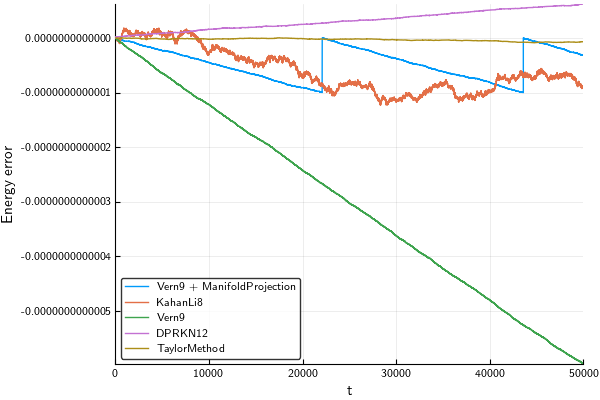

In [7]:
compare(tmax=5e4)

We can see that as the simulation time increases, the energy error increases. For this particular example the energy error for all the methods is comparable. For relatively short simulation times, if a highly accurate solution is required, the symplectic method is not recommended as its energy error fluctuations are larger than for other methods.

We will now compare the in place with the out of place versions. In the plots bellow we will use a dashed line for the out of place versions.

In [8]:
function in_vs_out(;dyn_only=true, tmax=1e2)
    println("In place versions:")
    plt = compare(InPlace, dyn_only, tmax=tmax)
    println("\nOut of place versions:")
    plt = compare(OutOfPlace, false, plt; tmax=tmax)
end

in_vs_out (generic function with 1 method)

First, here is a summary of all the available methods for `tmax = 1e3`:

In place versions:
  0.088297 seconds (569.31 k allocations: 84.296 MiB, 25.76% gc time)
  0.303286 seconds (1.90 M allocations: 101.091 MiB, 56.69% gc time)
  0.828995 seconds (15.78 M allocations: 267.808 MiB, 69.53% gc time)
  0.007921 seconds (82.56 k allocations: 3.604 MiB)
  0.422230 seconds (1.72 M allocations: 261.793 MiB, 72.51% gc time)
Vern9 + ManifoldProjection max energy error: 5.578870698741412e-15
KahanLi8 max energy error: 1.815214645262131e-14
Vern9 max energy error: 1.3933298959045715e-14
DPRKN12 max energy error: 3.1363800445660672e-15
TaylorMethod max energy error: 5.551115123125783e-16

Out of place versions:
  0.066929 seconds (200.20 k allocations: 26.270 MiB, 7.62% gc time)
  0.016425 seconds (120.35 k allocations: 10.408 MiB)
  0.004074 seconds (40.45 k allocations: 2.080 MiB)
KahanLi8 max energy error: 1.2712053631958042e-14
Vern9 max energy error: 1.304512053934559e-14
DPRKN12 max energy error: 1.3322676295501878e-15



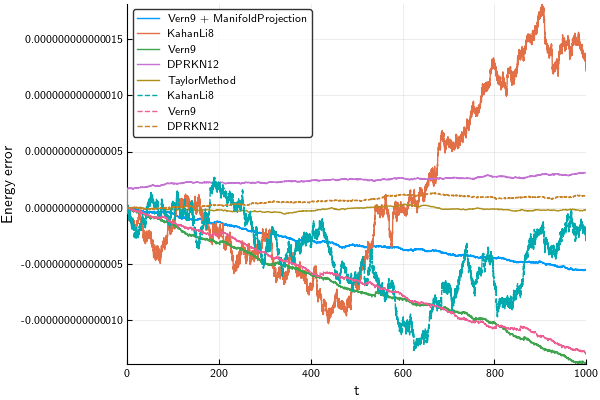

In [10]:
in_vs_out(dyn_only=false, tmax=1e3)

Now we will compare the in place and the out of place versions, but only for the integrators that are compatible with `StaticArrays`

In place versions:
  0.011003 seconds (190.21 k allocations: 10.319 MiB)
  0.038505 seconds (1.58 M allocations: 26.838 MiB, 28.11% gc time)
  0.000723 seconds (9.00 k allocations: 407.922 KiB)
KahanLi8 max energy error: 4.9404924595819466e-15
Vern9 max energy error: 1.4988010832439613e-15
DPRKN12 max energy error: 2.220446049250313e-15

Out of place versions:
  0.006205 seconds (20.19 k allocations: 3.287 MiB)
  0.002172 seconds (12.32 k allocations: 1.002 MiB)
  0.000779 seconds (4.31 k allocations: 241.203 KiB)
KahanLi8 max energy error: 2.7478019859472624e-15
Vern9 max energy error: 1.3600232051658168e-15
DPRKN12 max energy error: 1.6653345369377348e-16



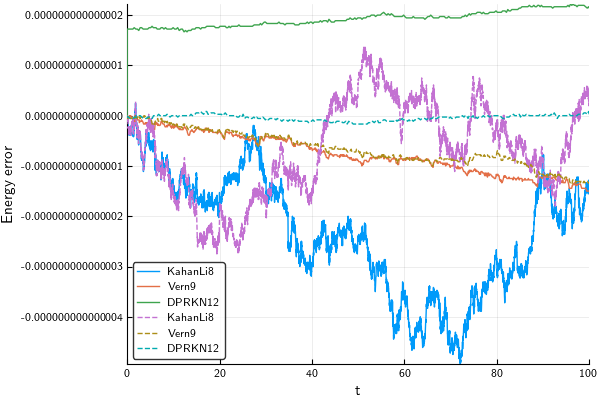

In [11]:
in_vs_out(tmax=1e2)

In place versions:
  0.253238 seconds (1.90 M allocations: 101.091 MiB, 50.39% gc time)
  0.623709 seconds (15.78 M allocations: 267.808 MiB, 58.52% gc time)
  0.022047 seconds (82.56 k allocations: 3.604 MiB, 60.22% gc time)
KahanLi8 max energy error: 1.815214645262131e-14
Vern9 max energy error: 1.3933298959045715e-14
DPRKN12 max energy error: 3.1363800445660672e-15

Out of place versions:
  0.068624 seconds (200.20 k allocations: 26.270 MiB, 6.98% gc time)
  0.019318 seconds (120.35 k allocations: 10.408 MiB)
  0.004269 seconds (40.45 k allocations: 2.080 MiB)
KahanLi8 max energy error: 1.2712053631958042e-14
Vern9 max energy error: 1.304512053934559e-14
DPRKN12 max energy error: 1.3322676295501878e-15



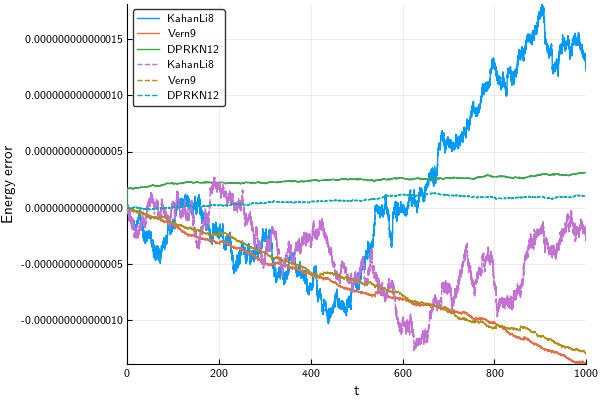

In [12]:
in_vs_out(tmax=1e3)

In place versions:
  2.474431 seconds (19.00 M allocations: 966.797 MiB, 49.09% gc time)
 11.686484 seconds (157.84 M allocations: 2.613 GiB, 72.13% gc time)
  0.145870 seconds (819.27 k allocations: 35.250 MiB, 55.73% gc time)
KahanLi8 max energy error: 3.1585845050585704e-14
Vern9 max energy error: 1.22291066162461e-13
DPRKN12 max energy error: 1.607047828144914e-14

Out of place versions:
  0.842469 seconds (2.00 M allocations: 208.599 MiB, 26.67% gc time)
  0.341513 seconds (1.20 M allocations: 97.305 MiB, 54.18% gc time)
  0.041196 seconds (402.82 k allocations: 19.796 MiB)
KahanLi8 max energy error: 5.5261351050717167e-14
Vern9 max energy error: 1.2070899835237014e-13
DPRKN12 max energy error: 1.2323475573339238e-14



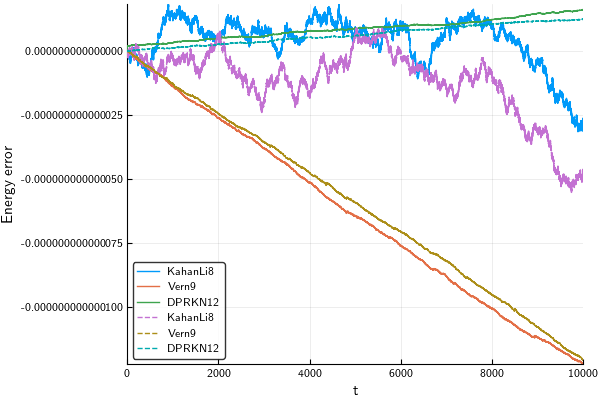

In [13]:
in_vs_out(tmax=1e4)

In place versions:
 19.221832 seconds (95.00 M allocations: 4.799 GiB, 66.76% gc time)
176.520926 seconds (789.20 M allocations: 13.041 GiB, 90.82% gc time)
  5.818386 seconds (4.09 M allocations: 178.146 MiB, 94.93% gc time)
KahanLi8 max energy error: 1.2331802246023926e-13
Vern9 max energy error: 5.982436768192656e-13
DPRKN12 max energy error: 6.242228955954943e-14

Out of place versions:
  3.742668 seconds (10.00 M allocations: 1.183 GiB, 16.67% gc time)
  1.069925 seconds (6.00 M allocations: 463.360 MiB, 29.00% gc time)
  0.208539 seconds (2.01 M allocations: 99.415 MiB)
KahanLi8 max energy error: 9.181544413650045e-14
Vern9 max energy error: 6.08457728645817e-13
DPRKN12 max energy error: 6.530886942357483e-14



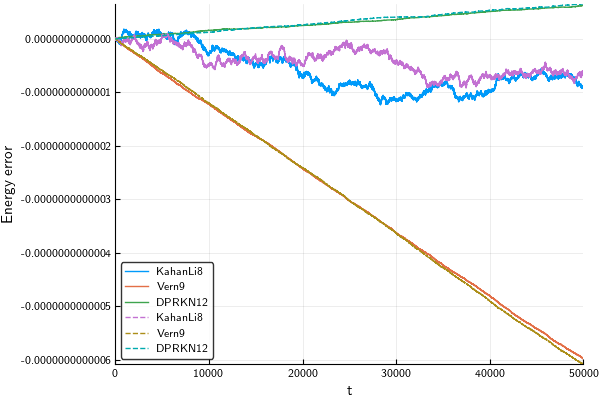

In [14]:
in_vs_out(tmax=5e4)

As we see from the above comparisons, the `StaticArray` versions are significantly faster and use less memory. The speedup provided for the out of place version is more proeminent at larger `tmax`. The most remarkable is the case of `Vern9` at `tmax = 5e4` where the difference is greater that 100x.

The benchmarks were performed on a machine with

In [15]:
versioninfo()

Julia Version 0.6.2
Commit d386e40c17 (2017-12-13 18:08 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-4720HQ CPU @ 2.60GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, haswell)
